In [1]:
import os
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import autosklearn.regression as autoreg
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from functions import *


/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [10]:
train = pd.read_csv("../data/train_solar.csv", index_col = 'timestamp')
test = pd.read_csv("../data/test_solar.csv", index_col = 'timestamp')

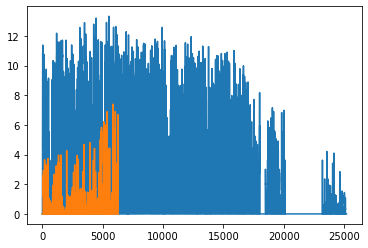

In [9]:
plt.plot(train.energy.to_numpy())
plt.plot(test.energy.to_numpy())

In [11]:
train = extract_dmhq(train)
test = extract_dmhq(test)

In [12]:
## Shuffle by every two days
from sklearn.model_selection import train_test_split
data = pd.concat([train, test],axis = 0)
data = extract_dmhq(data)
cols = ['yd']
ftrain, ttrain = feature_target_construct(data, 'energy', 200, 192, 0, 1, cols, 4,
                                          wd_on = False, d_on = False,
                                          m_on = False, h_on = False, q_on = False)
data = pd.concat([ftrain, ttrain], axis = 1)

# now define random split groups
groups = [data for _, data in data.groupby('yd1(t+0)')]
random.shuffle(groups,)

for i, df in enumerate(groups):
    data['yd1(t+0)'] = i+1
shuffled = pd.concat(groups).reset_index(drop=True)
ftrain = shuffled.iloc[:,1:201]
ttrain = shuffled.iloc[:,201:]

## split in 7/3 manner
train_X, test_X, train_Y, test_Y = train_test_split(ftrain, ttrain, train_size = 0.7, shuffle = False)

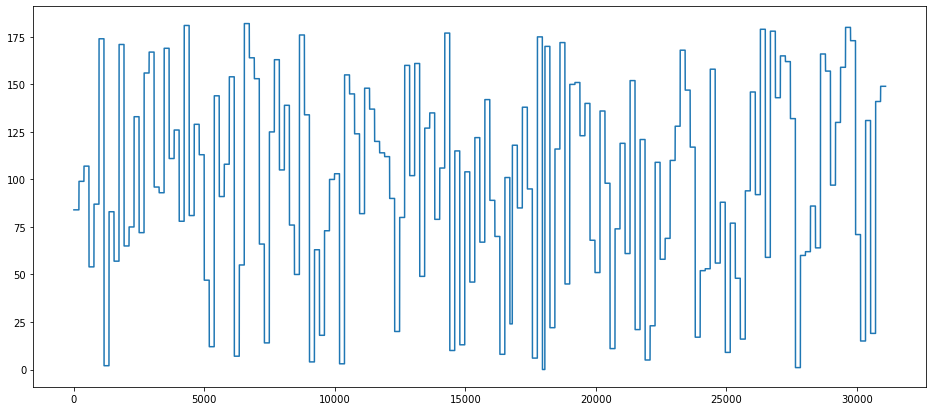

In [15]:
# A shuffle per two day overview
plt.figure(figsize = (16,7))
plt.plot(shuffled['yd1(t+0)'])

In [ ]:
# Auto-sklearn model with 10 hr run, exclude estimators with 
# appearntly bad performance and occupying time budgets
from sklearn.model_selection import TimeSeriesSplit, KFold
reg = autoreg.AutoSklearnRegressor(time_left_for_this_task=36000,
                                           per_run_time_limit=3600,
                                           initial_configurations_via_metalearning=0,
                                           ensemble_size=50, 
                                           ensemble_nbest=25,
                                           ensemble_memory_limit=5120, 
                                           seed=121, ml_memory_limit=10092, 
                                           include_estimators=None,
                                           exclude_estimators=['gaussian_process',
                                                               'k_nearest_neighbors',
                                                               'decision_tree'], 
                                           include_preprocessors=None, 
                                           exclude_preprocessors=None, 
                                           resampling_strategy = 'cv',
                                           resampling_strategy_arguments={'folds':5,
                                                                          'shuffle': False},
                                           tmp_folder=None, 
                                           output_folder=None, 
                                           delete_tmp_folder_after_terminate=False, 
                                           delete_output_folder_after_terminate=False, 
                                           shared_mode=False, 
                                           n_jobs = 3, 
                                           disable_evaluator_output=False, 
                                           get_smac_object_callback=None, 
                                           smac_scenario_args=None, 
                                           logging_config=None,
                                           metadata_directory=None)


reg.fit(train_X, train_Y)

In [48]:
from pickle import dump
## pickle the model
dump(reg, open('200lag_10hr','wb'))

In [2]:
## load model
from pickle import load
with open('solar_200lag_10hr', 'rb') as pickcle_file:
    model = load(pickcle_file)

In [5]:
## Selected ensemble model summary
print(model.get_models_with_weights())
print(model.sprint_statistics())

[(0.56, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'regressor:__choice__': 'ridge_regression', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.06679923104211231, 'feature_preprocessor:feature_agglomeration:affinity': 'manhattan', 'feature_preprocessor:feature_agglomeration:linkage': 'complete', 'feature_preprocessor:feature_agglomeration:n_clusters': 149, 'feature_preprocessor:feature_agglomeration:pooling_func': 'max', 'regressor:ridge_regression:alpha': 398.2364083728594, 'regressor:ridge_regression:fit_intercept': 'True', 'regressor:r

In [17]:
ypred = model.predict(test_X)
yhat = model.predict(train_X)
print("-----Test-----")
get_eval(test_Y, ypred)
print("-----Train-----")
get_eval(train_Y, yhat)

-----Test-----
MSE: 2.1553519510202896
MAE: 0.7499734893091902
r2_score: 0.666444965174683
-----Train-----
MSE: 2.2358213802921134
MAE: 0.7966653367781004
r2_score: 0.6759205803550663


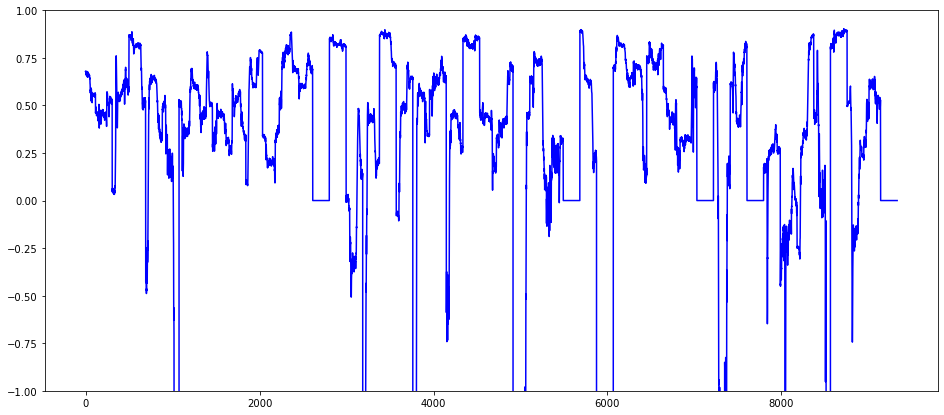

In [22]:
## testing set r2_score overtime
from sklearn.metrics import r2_score

r2l_list_test = []
for i in range(test_Y.shape[0]):
    o_y = np.transpose(test_Y.iloc[i,:].to_numpy().reshape(1,-1))
    p_y = np.transpose(ypred[i,:].reshape(1,-1))
    r2 = r2_score(o_y, p_y)
    r2l_list_test.append(r2)
fig = plt.figure(figsize = (16, 7))
plt.ylim(-1, 1)
plt.plot(r2l_list_test, 'b-')

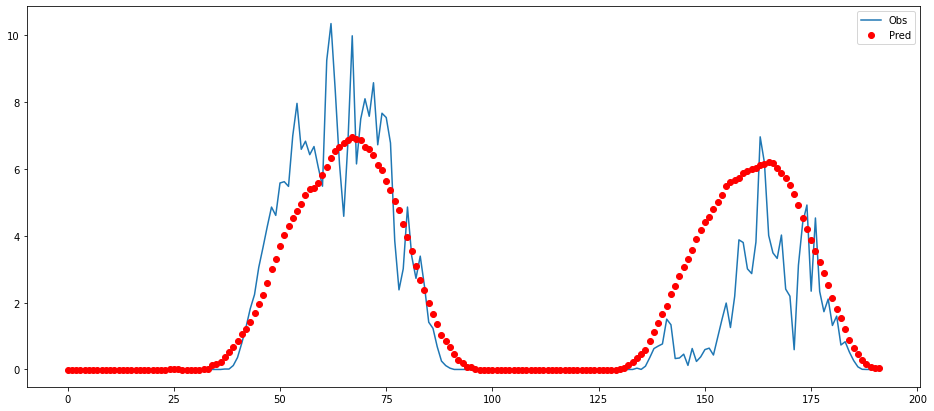

In [28]:
## sample plot of prediction
plt.figure(figsize=(16,7))
observation = plt.plot(test_Y.to_numpy()[0,])
prediction = plt.plot(ypred[0,], 'ro')
plt.legend(('Obs','Pred'))

In [5]:
model.refit(ftrain, ttrain)

/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=False,
                     disable_evaluator_output=False, ensemble_memory_limit=5120,
                     ensemble_nbest=25, ensemble_size=50,
                     exclude_estimators=['gaussian_process',
                                         'k_nearest_neighbors',
                                         'decision_tree'],
                     exclude_preprocessors=None, get_smac_object_callback=None,
                     include_estimators...
                     initial_configurations_via_metalearning=0,
                     logging_config=None, max_models_on_disc=50,
                     metadata_directory='solar_meta', metric=None,
                     ml_memory_limit=10092, n_jobs=4, output_folder=None,
                     per_run_time_limit=3600, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 5,
                     

## Confidence Interval failed(probably caused by shuffling before split)

In [35]:
from sklearn.utils import resample
n_bootstraps = 50
b_x = []
b_y = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(train_X, train_Y, n_samples = 19000)
    b_x.append(sample_X)
    b_y.append(sample_y)

In [36]:
prediction = []

for i, feature in enumerate(b_x):
    model.refit(feature, b_y[i])
    prediction.append(model.predict(test_X))

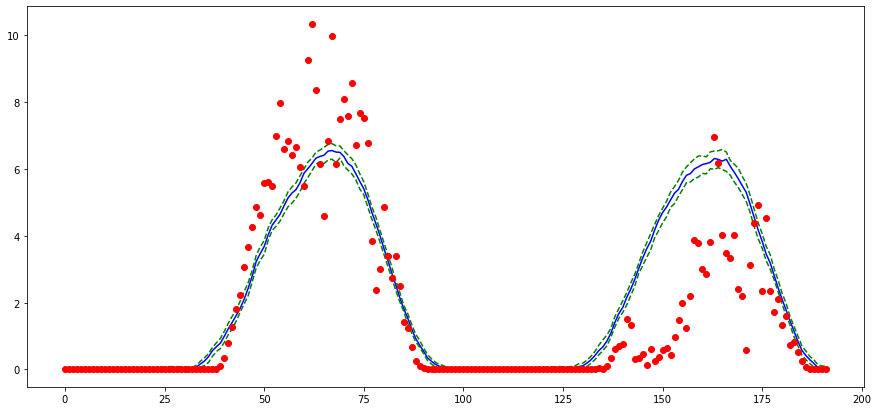

In [37]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction, 0.5, axis = 0)[0,:], 'b-')
plt.plot(np.quantile(prediction, 0.9, axis = 0)[0,:], 'g--')
plt.plot(np.quantile(prediction, 0.1, axis = 0)[0,:], 'g--')
plt.plot(test_Y.to_numpy()[0,:], 'ro')

## Toy models(w/o feature preprocessing, selection, and hyper-parameter tuning)

**Ridge**

In [38]:
from sklearn.linear_model import Ridge
rr = Ridge()
rr.fit(train_X, train_Y)
rr_yhat = rr.predict(train_X)
rr_ypred = rr.predict(test_X)

print("-----Train-----")
get_eval(train_Y, rr_yhat)
print("-----Test-----")
get_eval(test_Y, rr_ypred)

-----Train-----
MSE: 2.2549453594748843
MAE: 0.826824724593482
r2_score: 0.6731485842870959
-----Test-----
MSE: 2.2382851595033237
MAE: 0.7858597645917681
r2_score: 0.6536105001442091


**Knn**

In [43]:
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_jobs=4)
knnr.fit(train_X, train_Y)
knnr_yhat = knnr.predict(train_X)
knnr_ypred = knnr.predict(test_X)

print("-----Train-----")
get_eval(train_Y, knnr_yhat)
print("-----Test-----")
get_eval(test_Y, knnr_ypred)

-----Train-----
MSE: 0.6035384454794331
MAE: 0.33522448939404126
r2_score: 0.9125178823011231
-----Test-----
MSE: 2.9746933460815055
MAE: 0.7914088227902246
r2_score: 0.5396464404910014


**Extra Trees**

In [39]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_jobs = 2)
etr.fit(train_X, train_Y)
etr_yhat = etr.predict(train_X)
etr_ypred = etr.predict(test_X)

print("-----Train-----")
get_eval(train_Y, etr_yhat)
print("-----Test-----")
get_eval(test_Y, etr_ypred)

-----Train-----
MSE: 0.003704611494060908
MAE: 0.004647528097467425
r2_score: 0.9994630213515321
-----Test-----
MSE: 1.9494784765101467
MAE: 0.6673207915146459
r2_score: 0.6983052532020435


**MLP**

In [40]:
from sklearn.neural_network import MLPRegressor
mlpr = MLPRegressor()
mlpr.fit(train_X, train_Y)
mlpr_yhat = mlpr.predict(train_X)
mlpr_ypred = mlpr.predict(test_X)

print("-----Train-----")
get_eval(train_Y, mlpr_yhat)
print("-----Test-----")
get_eval(test_Y, mlpr_ypred)

-----Train-----
MSE: 1.5772867355773965
MAE: 0.7366522216795914
r2_score: 0.7713743260596291
-----Test-----
MSE: 2.2190971905069032
MAE: 0.8464259604292211
r2_score: 0.6565799658334661


/home/charles/anaconda3/envs/autosk07/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
